## Подготовка данных и раздведовательный анализ

In [45]:
# imports
import pandas as pd
import numpy as np

#### Константы
- путь к данным
- признаки, описывающие состояние ТС

In [46]:
DATA_PATH = 'data/vehicle_dataset_public/'

TAGS = ['fuelLevel', 'ingection', 'refueling2',
        'speedAndHeight', 'tachometer']

In [47]:
def dict_df_vehicle_i(i):
    dict_df_vehicle = {}
    for tag in TAGS:
        dict_df_vehicle[tag] = pd.read_csv(DATA_PATH +
                                            f'vehicle{i}_{tag}_public.csv', sep=';')
    return dict_df_vehicle

In [48]:
dict_df = dict_df_vehicle_i(1)

In [49]:
dict_df.keys()

dict_keys(['fuelLevel', 'ingection', 'refueling2', 'speedAndHeight', 'tachometer'])

In [50]:
ref_df = dict_df['refueling2'].copy()

In [51]:
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,"46,7","38,4"
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,"38,4","56,7"
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,"56,3",51
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51,"43,9"
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,"43,9","23,5"


In [52]:
float_columns = ['STARTLEVEL', 'ENDLEVEL']

for col in float_columns:
    ref_df[col] = ref_df[col].str.replace(',', '.').astype(float)

datetime_columns = ['STARTDATE', 'ENDDATE']

for col in datetime_columns:
    ref_df[col] = pd.to_datetime(ref_df[col])

In [53]:
ref_df['duration'] = ref_df['ENDDATE'] - ref_df['STARTDATE']
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4,02:18:00
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7,00:05:06
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0,03:08:21
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9,01:26:39
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5,03:00:04


In [54]:
ref_df['duration'].describe()

count                       103
mean     0 days 01:32:47.621359
std      0 days 01:12:55.148053
min             0 days 00:01:00
25%      0 days 00:08:39.500000
50%             0 days 01:40:27
75%      0 days 02:32:39.500000
max             0 days 03:50:23
Name: duration, dtype: object

In [55]:
duration_components = ref_df['duration'].dt.components[['hours', 'minutes', 'seconds']]
duration_components.head()

,hours,minutes,seconds
0,2,18,0
1,0,5,6
2,3,8,21
3,1,26,39
4,3,0,4


In [56]:
# длительность в минутах
ref_df['duration_minutes'] = np.dot(duration_components, [60, 1, 1/60])
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration,duration_minutes
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4,02:18:00,138.000000
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7,00:05:06,5.100000
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0,03:08:21,188.350000
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9,01:26:39,86.650000
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5,03:00:04,180.066667


In [57]:
# скорость изменения объема топлива
ref_df['LPM'] = (ref_df['ENDLEVEL'] - ref_df['STARTLEVEL']) / ref_df['duration_minutes'] # liters per minute
ref_df.head()

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration,duration_minutes,LPM
0,1,2020-01-16 11:02:40,2020-01-16 13:20:40,46.7,38.4,02:18:00,138.000000,-0.060145
1,1,2020-01-16 13:20:40,2020-01-16 13:25:46,38.4,56.7,00:05:06,5.100000,3.588235
2,1,2020-01-17 09:05:49,2020-01-17 12:14:10,56.3,51.0,03:08:21,188.350000,-0.028139
3,1,2020-01-17 14:45:48,2020-01-17 16:12:27,51.0,43.9,01:26:39,86.650000,-0.081939
4,1,2020-01-20 09:44:03,2020-01-20 12:44:07,43.9,23.5,03:00:04,180.066667,-0.113291


In [58]:
ref_df['LPM'].describe()

count    103.000000
mean       2.709313
std        6.103922
min       -0.201195
25%       -0.084062
50%       -0.060791
75%        3.628202
max       38.100000
Name: LPM, dtype: float64

In [59]:
import seaborn as sns

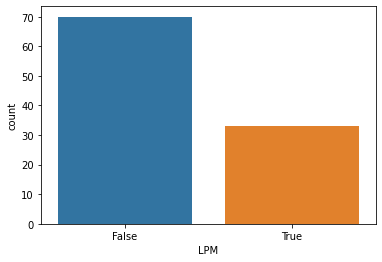

In [60]:
# Заправка/слив
sns.countplot(ref_df['LPM'] > 0)

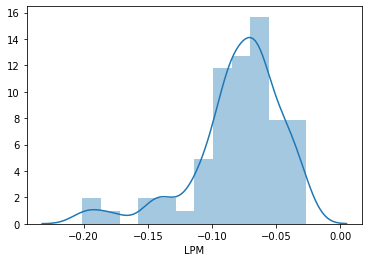

In [61]:
# Это, как я понимаю, сливы
# Интересно, с какой скоростью топливо расходуется при движении
sns.distplot(ref_df.loc[ref_df['LPM'] < 0, 'LPM'])

In [62]:
# Теперь для всех ТС

In [63]:
def process_refueling_df(df):
    ref_df = df.copy()
    
    float_columns = ['STARTLEVEL', 'ENDLEVEL']
    
    for col in float_columns:
        if ref_df[col].dtype == 'object':
            ref_df[col] = ref_df[col].str.replace(',', '.').astype(float)
    
    datetime_columns = ['STARTDATE', 'ENDDATE']

    for col in datetime_columns:
        ref_df[col] = pd.to_datetime(ref_df[col])
    
    ref_df['duration'] = ref_df['ENDDATE'] - ref_df['STARTDATE']
    
    duration_components = ref_df['duration'].dt.components[['hours', 'minutes', 'seconds']]
    
    ref_df['duration_seconds'] = np.dot(duration_components, [60, 1, 1/60])*60
    
    ref_df['LPM'] = (ref_df['ENDLEVEL'] - ref_df['STARTLEVEL']) / ref_df['duration_seconds']
    
    return ref_df

In [64]:
vehicle_ids = [1, 3, 5, 19, 28]

ref_dfs = {}

for vehicle_id in vehicle_ids:
    dict_df = dict_df_vehicle_i(vehicle_id)
    
    ref_df = dict_df['refueling2']
    
    ref_df = process_refueling_df(ref_df)
    
    ref_dfs[vehicle_id] = ref_df

In [65]:
desc_series = [ref_dfs[vehicle_id]['LPM'].describe() for vehicle_id in ref_dfs]

pd.DataFrame(np.transpose(desc_series), columns=vehicle_ids, index=desc_series[0].index)

,1,3,5,19,28
count,103.000000,25.000000,144.000000,22.000000,69.000000
mean,0.045155,0.047532,0.041923,0.012718,0.037276
std,0.101732,0.149256,0.106549,0.066184,0.060758
min,-0.003353,-0.195625,-0.125000,-0.085417,-0.002292
25%,-0.001401,-0.002714,-0.002002,-0.001815,-0.001530
50%,-0.001013,-0.002261,-0.001461,-0.000925,-0.001106
75%,0.060470,-0.001343,-0.000867,-0.000527,0.087667
max,0.635000,0.387222,0.576667,0.185510,0.252500


In [66]:
# очевидных сливов очень мало
# наверное, хитрецы сливают со скоростью расхода при движении
# судя по всему, очень пригодится скорость из speedAndHeight
pd.concat([ref_dfs[vehicle_id].loc[ref_dfs[vehicle_id]['LPM'] < -1] for vehicle_id in ref_dfs], axis=0)

,TSID,STARTDATE,ENDDATE,STARTLEVEL,ENDLEVEL,duration,duration_seconds,LPM
